In [8]:
import tensorflow as tf
from src.dataset import dataset_tf
from src.audio import to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks
from src.plots import plot_history, plot_spectrograms

In [9]:
train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure")

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (32, 4000)
Example label shape: (32,)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [10]:
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

(118, 129, 1)


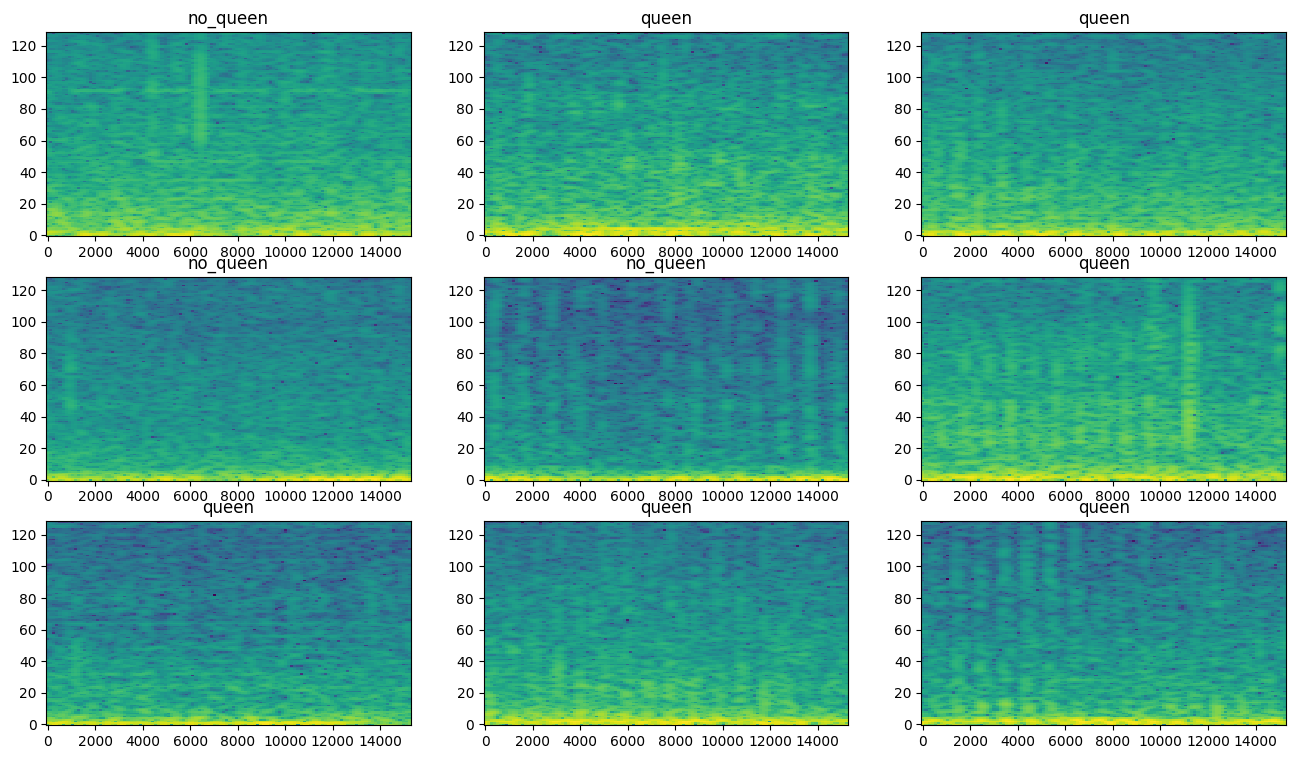

In [11]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [12]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Sequential model

In [13]:
model_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

2024-03-02 16:09:44.438980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [14]:
history = model_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60


2024-03-02 16:09:45.760925: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - 1s 28ms/step - loss: 0.6319 - accuracy: 0.6073 - val_loss: 0.5690 - val_accuracy: 0.6316
Epoch 2/60
22/22 [==============================] - 0s 14ms/step - loss: 0.4666 - accuracy: 0.7664 - val_loss: 0.4197 - val_accuracy: 0.7836
Epoch 3/60
22/22 [==============================] - 0s 13ms/step - loss: 0.3205 - accuracy: 0.8438 - val_loss: 0.2713 - val_accuracy: 0.8889
Epoch 4/60
22/22 [==============================] - 0s 13ms/step - loss: 0.2007 - accuracy: 0.9328 - val_loss: 0.1603 - val_accuracy: 0.9591
Epoch 5/60
22/22 [==============================] - 0s 13ms/step - loss: 0.1680 - accuracy: 0.9372 - val_loss: 0.1468 - val_accuracy: 0.9649
Epoch 6/60
22/22 [==============================] - 0s 13ms/step - loss: 0.1532 - accuracy: 0.9416 - val_loss: 0.1493 - val_accuracy: 0.9591
Epoch 7/60
22/22 [==============================] - 0s 13ms/step - loss: 0.1382 - accuracy: 0.9474 - val_loss: 0.1615 - val_accuracy: 0.9591
Epoch 8/60
22/22 [======

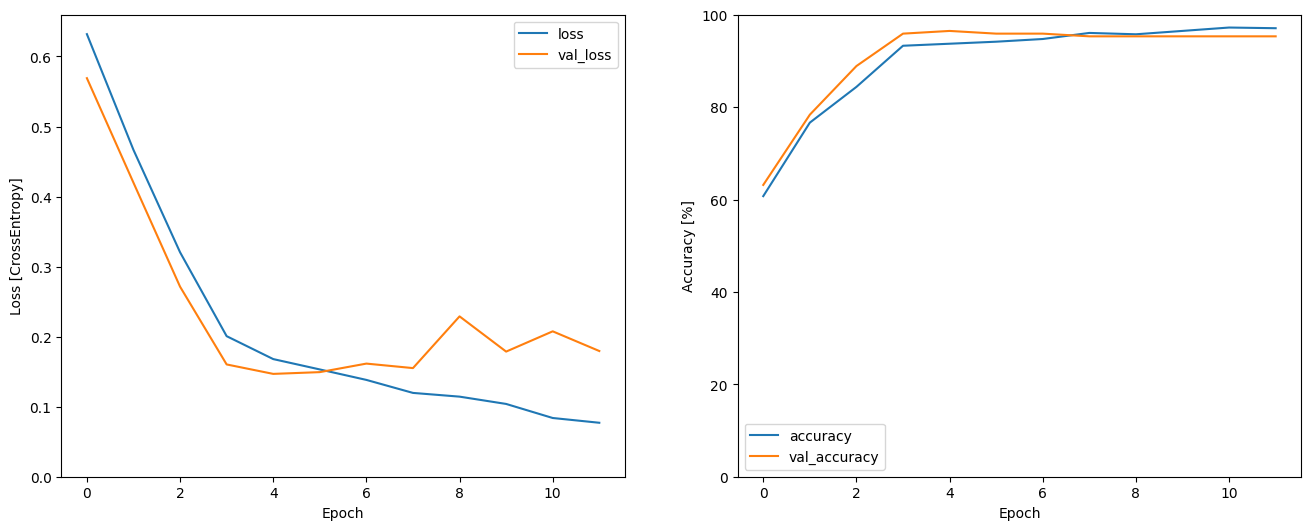

In [15]:
plot_history(history)

# Convolutional

In [16]:
model_conv = get_conv_model(input_shape, len(label_names))
model_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [17]:
history = model_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
22/22 [==============================] - 1s 40ms/step - loss: 0.5594 - accuracy: 0.6642 - val_loss: 0.4026 - val_accuracy: 0.8246
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.3193 - accuracy: 0.8730 - val_loss: 0.2331 - val_accuracy: 0.9064
Epoch 3/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1996 - accuracy: 0.9285 - val_loss: 0.2717 - val_accuracy: 0.8772
Epoch 4/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1863 - accuracy: 0.9358 - val_loss: 0.1362 - val_accuracy: 0.9649
Epoch 5/50
22/22 [==============================] - 0s 18ms/step - loss: 0.1881 - accuracy: 0.9358 - val_loss: 0.1729 - val_accuracy: 0.9064
Epoch 6/50
22/22 [==============================] - 0s 17ms/step - loss: 0.1566 - accuracy: 0.9489 - val_loss: 0.1314 - val_accuracy: 0.9591
Epoch 7/50
22/22 [==============================] - 0s 16ms/step - loss: 0.1475 - accuracy: 0.9474 - val_loss: 0.1388 - val_accuracy: 0.9591
Epoch 8/50
22

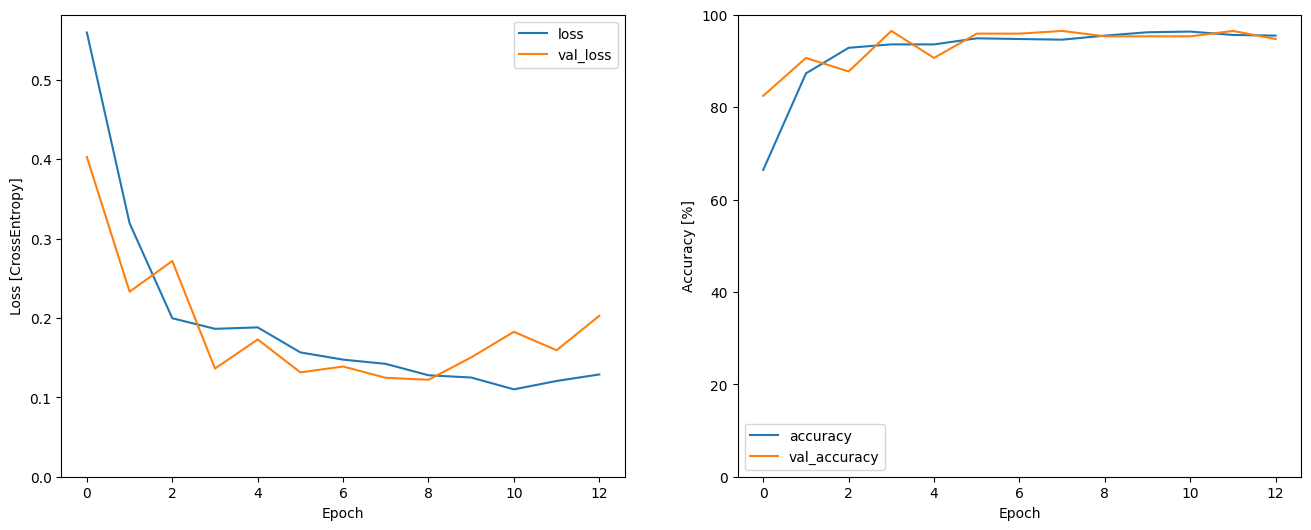

In [18]:
plot_history(history)